# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
%pylab inline
import os.path
import jax
import jax.numpy as np
import jax_cosmo as jc

Populating the interactive namespace from numpy and matplotlib


## Retrieving  the nz data

In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

Text(0.5, 0, 'z')

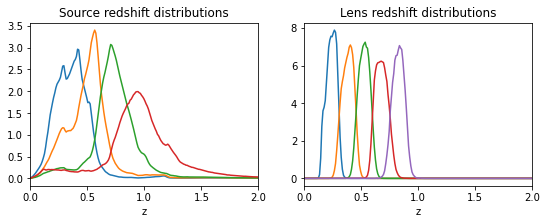

In [39]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')
subplot(122)
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,2);
title('Lens redshift distributions');
xlabel('z')

In [40]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,5)]

(0.0, 1.0)

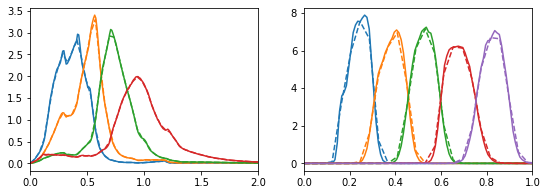

In [42]:
z = linspace(0,2)
figure(figsize=(9,3))
subplot(121)

for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)
subplot(122)

for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_l[i](z), '--', color='C%d'%i)
xlim(0,1)

##  Let's build  a model for C_ell

In [16]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [1.0, 2.0, 3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [DeviceArray(1., dtype=float32), DeviceArray(2., dtype=float32)])

In [46]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in 
         [1.4, 1.6, 1.6, 1.9, 2.0]] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

In [47]:
# Let's try it out
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.)

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.])

In [50]:
cl_3x2pt = mu(fid_params)

In [51]:
%timeit mu(fid_params).block_until_ready()

334 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


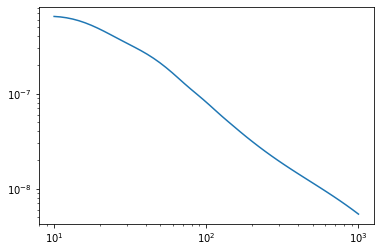

In [49]:
loglog(ell, cl_3x2pt[4])

In [55]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in 
         [1.4, 1.6, 1.6, 1.9, 2.0]] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25)
    
    return cov

In [56]:
C = cov(fid_params)

In [63]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [64]:
j = jacobian(fid_params)

In [61]:
%timeit jacobian(fid_params).block_until_ready()

1.88 s ± 70.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
# And we get the fisher matrix from the jacobian and covariance
F = np.einsum('ia,ij,jb',j,np.linalg.inv(C),j)

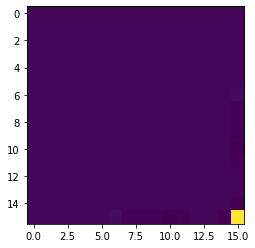

In [72]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:2,:2]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

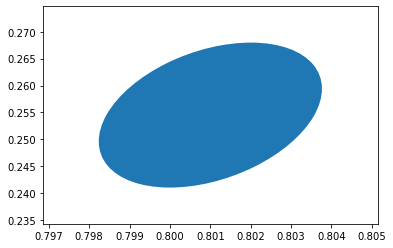

In [73]:
plot_contours(F, fid_params)